In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category = FutureWarning) 

# Oversampling/undersampling
from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

# Metrics
from sklearn import metrics
from sklearn.base import clone

%matplotlib inline

## Goals:
- Build a model able to predict churn
- Identify the key drivers of churn
- Flag customers at high risk of churning 

### Feature description:
- CustomerID = Self explanatory
- Gender = Male or Female
- SeniorCitizen = 1 == Yes; 0 == No
- Partner = Whether the custoimer has a partner (Yes/No)
- Dependents = Whether the customer has any dependents (Yes/No)
- tenure = Number of months the customer has stayed with  the company
- PhoneService = Whether the customer has phone service (Yes/No)
- MultipleLines = Whether the customer has multiple phone lines (Yes/No, No Phone Service)
- InternetService = Customer internet service provider (DSL, Fiber optic, no)
- OnlineSecurity = Whteher the customer has online security (Yes/No, No internet Service)
- OnlineBackup = Whether the customer has online backup (Yes/No, No internet Service)
- DeviceProtection = Whether the customer has device protection (Yes/No, No internet Service)
- TechSupport = Whether the customer has tech support(Yes/No, No internet Service)
- StreamingTV = Whether the customer has streaming tv(Yes/No, No internet Service)
- StreamingMovies = Whe ther the customer has streaming movies(Yes/No, No internet Service)
- Contract = The contract term of the customer (month to month, one year, two year)
- PaperlessBilling = Whether the customer has paperless billing(Yes/No)
- PaymentMethod = The customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges = Monthly charge
- TotalCharges = Total amount charged to the customer
- Churn = Whether customer churned (Yes/No

In [143]:
data = pd.read_csv('Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [144]:
# What's the size of the dataset
numRows, numCols = data.shape
print('There are {} rows and {} columns'.format(numRows, numCols))

There are 7043 rows and 21 columns


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 <a list of 21 Text xticklabel objects>)

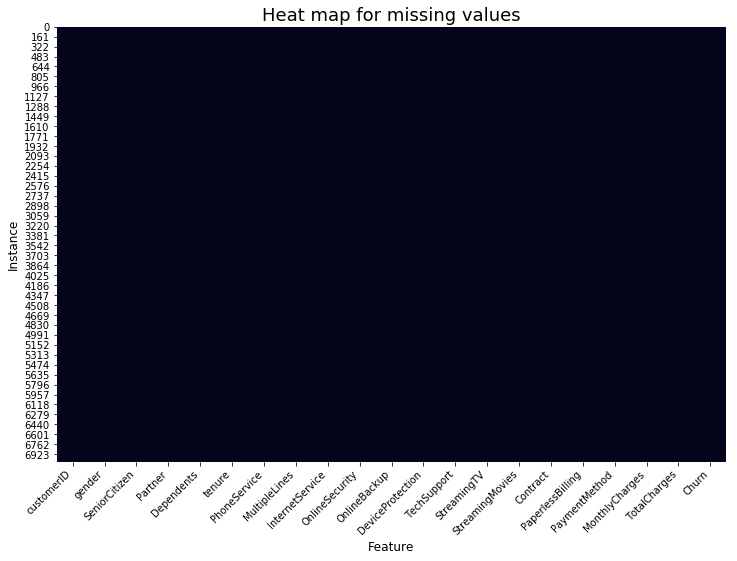

In [145]:
# Lets visualize missing values with a heatmap
# The heat map will clearly show dense areas of missing values. Non dense areas will show up as a couple of dots

plt.figure(figsize = (12,8))
sns.heatmap(data.isnull(), cbar = False)

plt.title('Heat map for missing values', fontsize = 18)
plt.ylabel('Instance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12)
plt.xticks(rotation = 45, ha = 'right')

#### It looks like there are no missing values
#### Lets double check

In [146]:
print('Number of missing values:', data.isnull().sum().sum())

Number of missing values: 0


In [147]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

#### For the most part dtypes are as expected for the type of data stored in a given column.
#### Exception: SeniorCitizen is a yes/no feature but is changed to 1/0 ans is reflected as dtype == int
#### TotalCharges is expected to be float. There are probably some invalid entries. Lets take a closer look.

In [148]:
# dtype to float, errors will be changed to np.nan
data['TotalCharges'] = pd.to_numeric(data.TotalCharges, errors = 'coerce')

In [149]:
# How many null are introduced?
data.TotalCharges.isnull().sum()

11

#### TotalCharges value is equal to the number of months with the company multiplied by Monthly charges. This assumes that monthly charges are the same through tenure.
#### Lets inputate null with tenre*MonthlyCharges for each null value

In [150]:
for i, val in enumerate(data.TotalCharges):
    if np.isnan(val) == True:
        data.TotalCharges.iloc[i] = data.tenure[i]*data.MonthlyCharges[i]

C:\Users\Jason Sosa\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [151]:
# Lets collect oject type and numeric ype colummns in two separate lists. I will use ths to plot the data
obj_type = []
numeric_type = []

for col in data.columns:
    if data[col].dtype == np.object_:
        obj_type.append(col)
    else: 
        numeric_type.append(col)

In [152]:
# Eliminating SenirCitizen from numeric type list. This is a cayegorical feature, si I'll add it to the categorical list later on
numeric_type.pop(numeric_type.index('SeniorCitizen'))

'SeniorCitizen'

In [153]:
# Dividing the dataframe into churn/non-churn. I wil use this for plotting histograms
data_churn = data[data.Churn == 'Yes']
data_NO_churn = data[data.Churn == 'No']

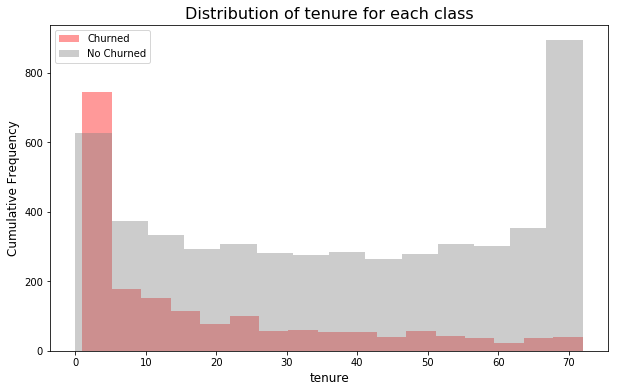

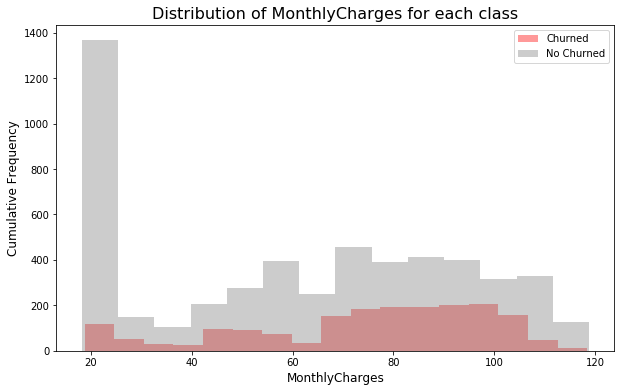

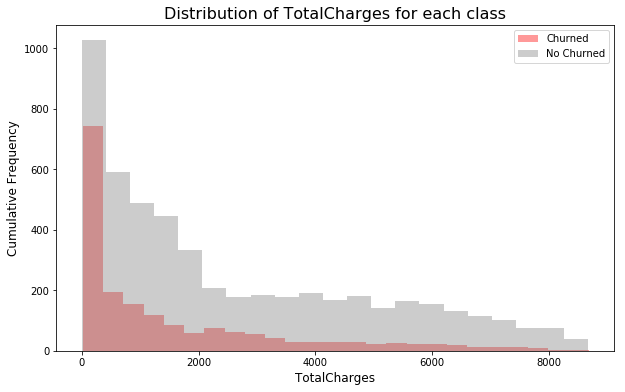

In [154]:
# Histogram of continuous feature for each class
# Helper function for plotting histograms of numeric features for churned vs non-churned

def bar_plot(col):
    
    for x in col: # Column iterator
        
        plt.figure(figsize = (10,6))

        sns.distplot(data_churn[x], kde = False, color = 'red', label = 'Churned')
        sns.distplot(data_NO_churn[x], kde = False, color = 'gray', label = 'No Churned')
        plt.legend()
        plt.ylabel('Cumulative Frequency', fontsize = 12)
        plt.xlabel(x, fontsize = 12)
        plt.title('Distribution of {} for each class'.format(x), fontsize = 16)

bar_plot(numeric_type)

### Notes: 
- Number of months as customer is longer for non-churned vs churned. (kind of expected). This data also suggests that a lot of effort must be put in place to increase customer engagement  and decrease churning.
- Distribution of monthly charges is siilar for both, churn and non_churn

In [155]:
# Eliminating churn from numeric type list
obj_type.pop(obj_type.index('Churn'))

'Churn'

In [156]:
# Adding SeniorCitizen feat name to object type
obj_type.append('SeniorCitizen')

In [157]:
# Dropping customerID feature.
obj_type.pop(obj_type.index('customerID'))

'customerID'

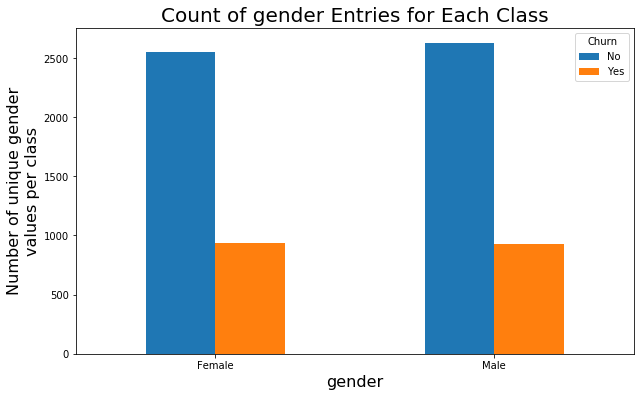

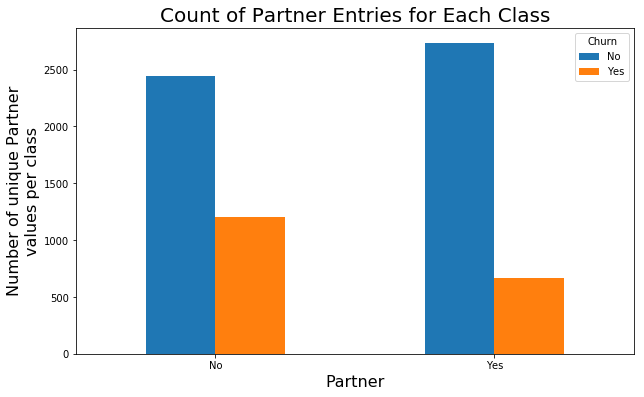

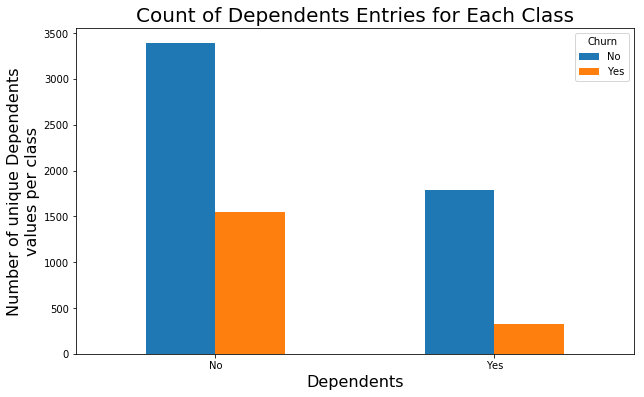

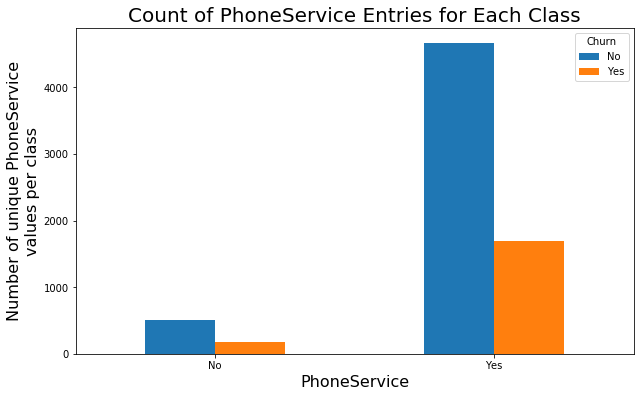

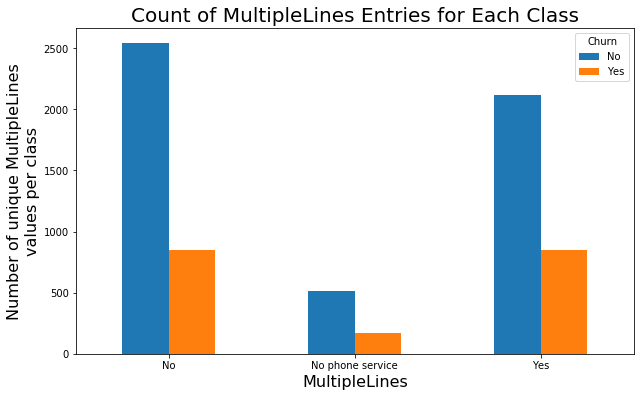

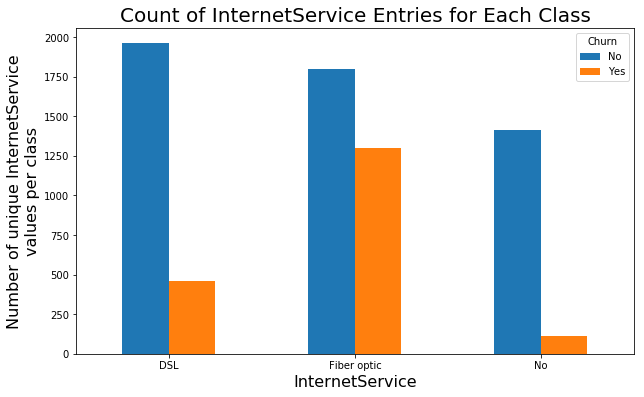

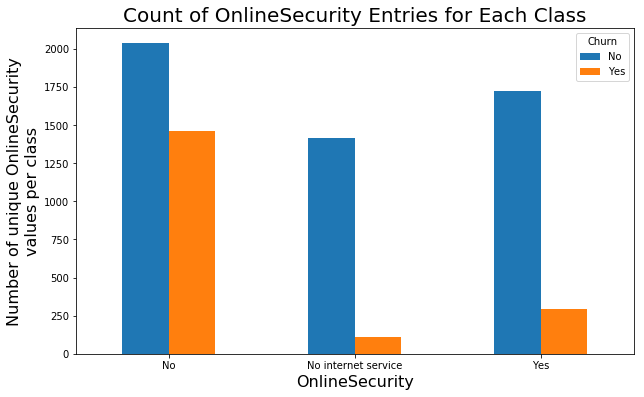

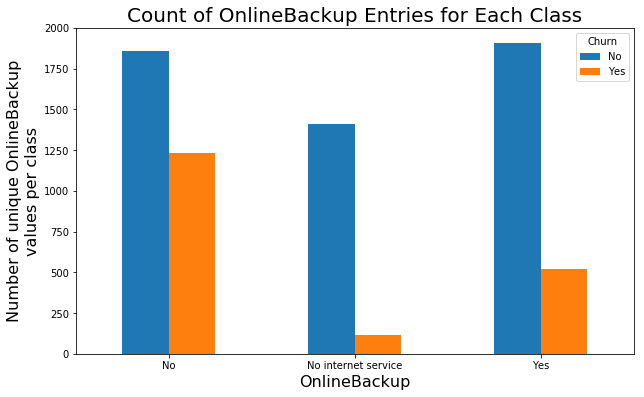

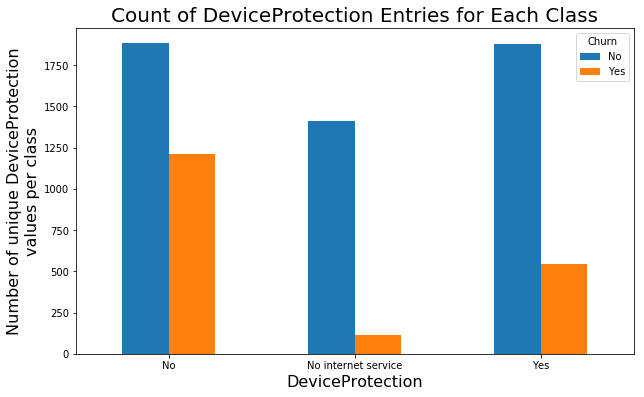

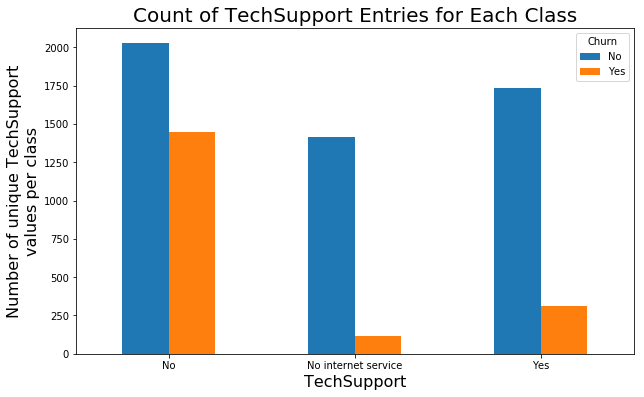

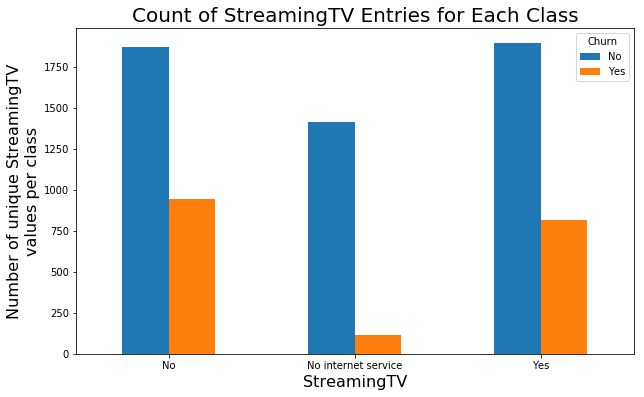

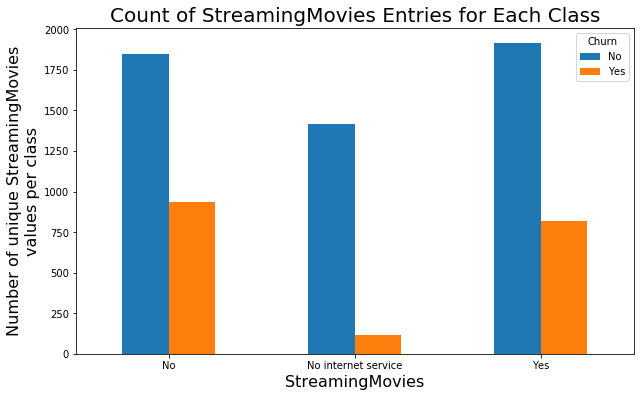

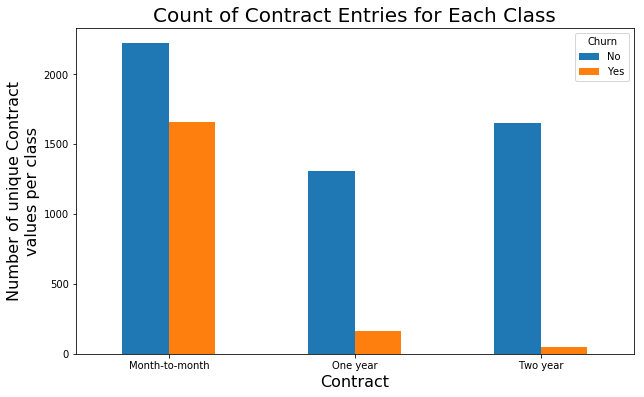

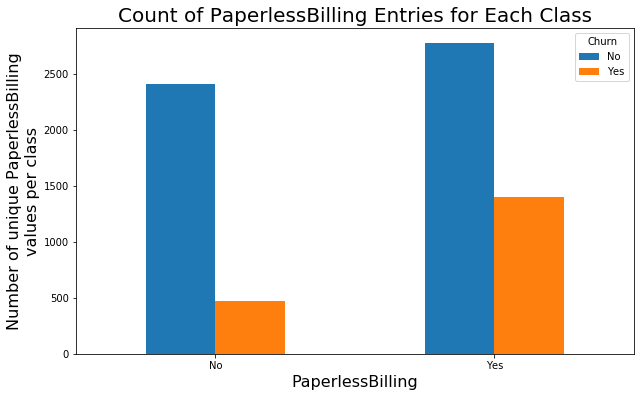

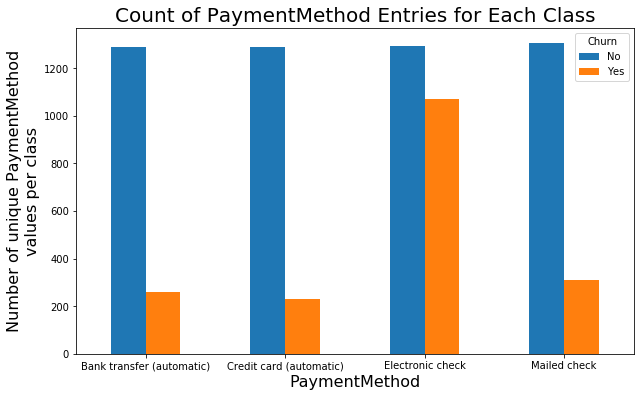

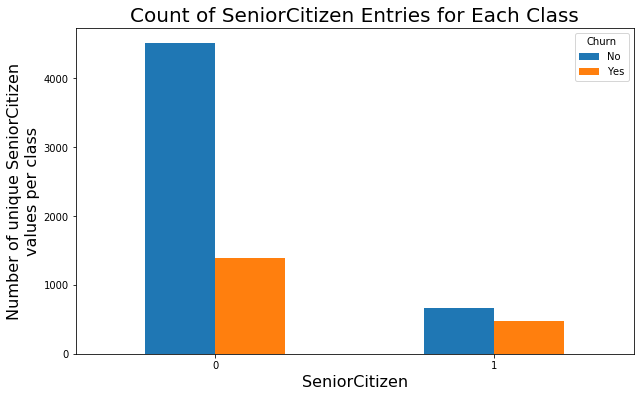

In [158]:
def cat_bar_plot(col_list):

    for x in col_list:
        plot = data.groupby([x, 'Churn'])['Churn'].count().unstack().plot(kind='bar', figsize=(10,6))
        plt.title('Count of {} Entries for Each Class'.format(x), fontsize=20)
        plt.ylabel('Number of unique {}\nvalues per class'.format(x), fontsize=16)
        plt.xlabel(x, fontsize=16)
        plt.xticks(rotation = 'horizontal')
        plt.show(plot)
        
cat_bar_plot(obj_type)

Text(0.5, 0, 'Churn')

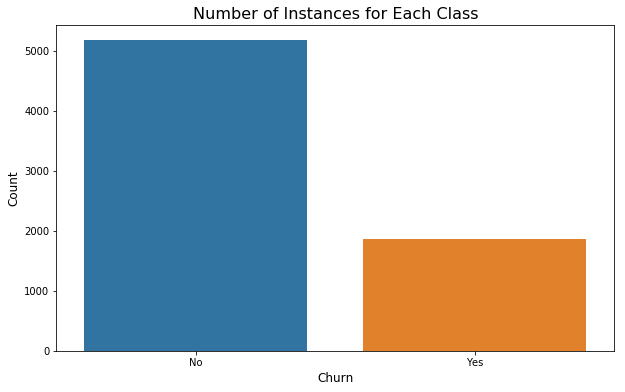

In [159]:
plt.figure(figsize = (10,6))

sns.countplot(data.Churn)
plt.title('Number of Instances for Each Class', fontsize = 16)
plt.ylabel('Count', fontsize = 12)
plt.xlabel('Churn', fontsize = 12)

In [250]:
perc_churn = (data_churn.Churn.count()/(data_churn.Churn.count()+data_NO_churn.Churn.count()))*100

print('The percentage of churned customers in the dataset is: {}'.format(perc_churn.round(2)))
print('The percentage of Non-churned customers in the dataset is: {}'.format((100-perc_churn).round(2)))

The percentage of churned customers in the dataset is: 26.54
The percentage of Non-churned customers in the dataset is: 73.46


### Clearly the classes are a bit imbalance. Let's first use random forest classifier since it is robust with imbalance classes.

# Data preprocessing

#### Lets transform Churn == target to 1/0, where 1 is a customer that churned, whereas 0 is a customer thta didn't churned.

In [161]:
data.Churn = [1 if x == 'Yes' else 0 for x in data.Churn]

In [162]:
# Chaning yes/no features to 1/0
to_transform = ['Partner', 'Dependents','PhoneService', 'PaperlessBilling']

for col_name in to_transform:
    data[col_name] = [1 if x == 'Yes' else 0 for x in data[col_name]]

In [163]:
# Get dummies for the rest of categorical features
col_to_encode = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                 'PaymentMethod']

data_encoded = pd.get_dummies(data, columns = col_to_encode)

In [164]:
encRows, encColumns = data_encoded.shape
print('The dimension of the encoded dataset is: {}'.format(encColumns))

The dimension of the encoded dataset is: 43


#### The numeric data has different scales, let's use StandarScaler to scale data

In [165]:
to_scale = data[numeric_type]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(to_scale)

C:\Users\Jason Sosa\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jason Sosa\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [166]:
# make a DataFrame from the scaled data
scaled_df = pd.DataFrame(data = scaled_data, columns = numeric_type)
scaled_df.head()

,tenure,MonthlyCharges,TotalCharges
0,-1.277445,-1.160323,-0.992611
1,0.066327,-0.259629,-0.172165
2,-1.236724,-0.362660,-0.958066
3,0.514251,-0.746535,-0.193672
4,-1.236724,0.197365,-0.938874


In [167]:
# drop unscaled data
data_encoded.drop(numeric_type, axis='columns', inplace = True)

In [168]:
# Merge scaled data
data_encoded[numeric_type] = scaled_df

In [169]:
data_encoded.shape

(7043, 43)

## Modeling

In [170]:
X = data_encoded.drop(['customerID', 'Churn'], axis='columns').copy()
y = data_encoded.Churn.copy()

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6059, stratify=y)

#### As I mentioned above, I'll use a random forest clf since they're robust to imbalanced classes.
#### Let's first look at baseline performance
#### Since I don't want to miss any churned customer I'll pay close attention to recall

In [32]:
# Baseline model
forest_param_grid = {
    'n_estimators':[10]
}

scorers = {
    'precision_score': metrics.make_scorer(metrics.precision_score),
    'recall_score': metrics.make_scorer(metrics.recall_score)
}

def grid_search_baseline(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints confussion matrix
    """
    forest_clf = RandomForestClassifier(n_jobs = -1)
    skf = StratifiedKFold(n_splits = 5)
    grid_search = GridSearchCV(forest_clf, param_grid = forest_param_grid, scoring = scorers,
                               refit = refit_score, cv = skf, return_train_score = True)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    # confusion matrix on the test data.
    print('Confusion matrix of baseline Random Forest')
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                 columns = ['Pred_Neg', 'Pred_Pos'], index = ['Neg', 'Pos']))
    return grid_search

grid_search_clf_baseline = grid_search_baseline(refit_score = 'recall_score')

Confusion matrix of baseline Random Forest
     Pred_Neg  Pred_Pos
Neg       933       102
Pos       220       154


In [33]:
results_baseline = pd.DataFrame(grid_search_clf_baseline.cv_results_)
results_baseline = results_baseline.sort_values(by='mean_test_recall_score', ascending=False)
results_baseline[['mean_test_precision_score',  'mean_train_precision_score', 'mean_test_recall_score',
                  'mean_train_recall_score', 'param_n_estimators']].round(3)

,mean_test_precision_score,mean_train_precision_score,mean_test_recall_score,mean_train_recall_score,param_n_estimators
0,0.627,0.991,0.458,0.938,10


#### Performance is quite poor, with a recall of < 0.5
#### Performance in train is quite good. Lets try to regularize the model.

In [34]:
# Baseline model
forest_param_grid = {
    'n_estimators':[100, 500], 
    'max_features':[5, 10, 25],
    'min_samples_split': [10, 50, 100]
}

scorers = {
    'precision_score': metrics.make_scorer(metrics.precision_score),
    'recall_score': metrics.make_scorer(metrics.recall_score)
}

def grid_search_baseline(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints confussion matrix
    """
    forest_clf = RandomForestClassifier(n_jobs = -1)
    skf = StratifiedKFold(n_splits = 5)
    grid_search = GridSearchCV(forest_clf, param_grid = forest_param_grid, scoring = scorers,
                               refit = refit_score, cv = skf, return_train_score = True)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    # confusion matrix on the test data.
    print('Confusion matrix of baseline Random Forest')
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                 columns = ['Pred_Neg', 'Pred_Pos'], index = ['Neg', 'Pos']))
    return grid_search

grid_search_clf_1 = grid_search_baseline(refit_score = 'recall_score')

Confusion matrix of baseline Random Forest
     Pred_Neg  Pred_Pos
Neg       937        98
Pos       189       185


In [35]:
results_rf_1 = pd.DataFrame(grid_search_clf_1.cv_results_)
results_rf_1 = results_rf_1.sort_values(by='mean_test_recall_score', ascending=False)
results_rf_1[['mean_test_precision_score',  'mean_train_precision_score', 'mean_test_recall_score',
              'mean_train_recall_score', 'param_n_estimators']].round(3)

,mean_test_precision_score,mean_train_precision_score,mean_test_recall_score,mean_train_recall_score,param_n_estimators
13,0.642,0.935,0.513,0.824,500
7,0.658,0.912,0.509,0.764,500
12,0.638,0.930,0.508,0.816,100
6,0.655,0.907,0.504,0.759,100
14,0.666,0.775,0.503,0.587,100
15,0.664,0.775,0.500,0.586,500
0,0.651,0.881,0.498,0.699,100
1,0.662,0.883,0.496,0.703,500
8,0.663,0.752,0.496,0.563,100
16,0.661,0.720,0.495,0.545,100


#### Performance is similar even with tuned hyperparameters
#### This is an indication that I may need to balanced the classes.

#### I'll balanced the classes using SMOTE. For this I will oversample the minority class and create synthetic datasets only for training data.
#### SMOTE oversamples by (1) Finding the k-nearest-neighbors for minority class observations. Then, (2) randomly chooses one of the k-nearest-neighbors and use it to create a similar, but randomly tweaked, new instance.
#### It is important to balance only training data after the data is split to avoid bleeding of the synthetic data into test set.

In [172]:
# Oversampling
sm = SMOTE(random_state=6059, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

#### Let's again estart with a random forest clf with default parameters to measure baeline performance and also compare it with imbalanced data

In [33]:
# Baseline model
forest_param_grid = {
    'n_estimators':[10]
}

scorers = {
    'precision_score': metrics.make_scorer(metrics.precision_score),
    'recall_score': metrics.make_scorer(metrics.recall_score),
    'auc_score': metrics.make_scorer(metrics.roc_auc_score)
}

def grid_search_baseline(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints confussion matrix
    """
    forest_clf = RandomForestClassifier(n_jobs = -1)
    skf = StratifiedKFold(n_splits = 5)
    grid_search = GridSearchCV(forest_clf, param_grid = forest_param_grid, scoring = scorers,
                               refit = refit_score, cv = skf, return_train_score = True)
    grid_search.fit(X_train_res, y_train_res)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    # confusion matrix on the test data.
    print('Confusion matrix of baseline Random Forest')
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                 columns = ['Pred_Neg', 'Pred_Pos'], index = ['Neg', 'Pos']))
    return grid_search

grid_search_clf_baseline = grid_search_baseline(refit_score = 'recall_score')

Confusion matrix of baseline Random Forest
     Pred_Neg  Pred_Pos
Neg       878       157
Pos       184       190


In [119]:
results_baseline = pd.DataFrame(grid_search_clf_baseline.cv_results_)
results_baseline = results_baseline.sort_values(by='mean_test_recall_score', ascending=False)
results_baseline[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_auc_score',
                  'mean_train_auc_score', 'param_n_estimators']].round(3)

,mean_test_precision_score,mean_test_recall_score,mean_test_auc_score,mean_train_auc_score,param_n_estimators
0,0.852,0.822,0.841,0.99,10


#### Quite and improvement!
#### Model is close to overfitting, let's regulaize it to see if we can improve performance.

In [61]:
# finding optimal hyperparameters
# The function is slightly modified from the above one
forest_param_grid = {
    'n_estimators':[100], 
    'max_features':[5, 10, 25, 41],
    'min_samples_split': [10, 50, 100]
}

scorers = {
    'precision_score': metrics.make_scorer(metrics.precision_score),
    'recall_score': metrics.make_scorer(metrics.recall_score),
    'auc_score': metrics.make_scorer(metrics.roc_auc_score)
}

def grid_search_wrapper(refit_score = 'recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    print parameters of best model
    prints classifier performance metrics
    """
    forest_clf = RandomForestClassifier(n_jobs = -1)
    skf = StratifiedKFold(n_splits = 5)
    grid_search = GridSearchCV(forest_clf, param_grid = forest_param_grid, scoring = scorers,
                               refit = refit_score, cv = skf, return_train_score = True)
    grid_search.fit(X_train_res, y_train_res)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                 columns = ['Pred_neg', 'Pred_pos'], index = ['Neg', 'Pos']))
    return grid_search

grid_search_clf_1 = grid_search_wrapper(refit_score = 'recall_score')

Best params for recall_score
{'max_features': 5, 'min_samples_split': 10, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     Pred_neg  Pred_pos
Neg       876       159
Pos       140       234


In [62]:
results_clf_1 = pd.DataFrame(grid_search_clf_1.cv_results_)
results_clf_1 = results_clf_1.sort_values(by='mean_test_recall_score', ascending=False)
results_clf_1[['mean_test_precision_score', 'mean_test_recall_score',
               'mean_test_auc_score', 'mean_train_auc_score',
               'param_max_features', 'param_min_samples_split']].round(3)

,mean_test_precision_score,mean_test_recall_score,mean_test_auc_score,mean_train_auc_score,param_max_features,param_min_samples_split
0,0.833,0.861,0.845,0.933,5,10
3,0.833,0.860,0.845,0.945,10,10
6,0.833,0.859,0.844,0.956,25,10
9,0.831,0.851,0.840,0.960,41,10
4,0.808,0.850,0.824,0.866,10,50
1,0.809,0.849,0.825,0.858,5,50
7,0.810,0.849,0.825,0.870,25,50
5,0.796,0.845,0.815,0.839,10,100
10,0.806,0.844,0.821,0.871,41,50
8,0.796,0.843,0.814,0.842,25,100


#### Let's do a finner gridsearch. Since the best parameters are in the low end I'll explore values in the 5 to 25 range.

In [175]:
# finding optimal hyperparameters
# The function is slightly modified from the above one
forest_param_grid = {
    'n_estimators': [100], 
    'max_features': [5, 8, 10, 15],
    'min_samples_split': [10, 15, 20, 25]
}

scorers = {
    'precision_score': metrics.make_scorer(metrics.precision_score),
    'recall_score': metrics.make_scorer(metrics.recall_score),
    'auc_score': metrics.make_scorer(metrics.roc_auc_score)
}

def grid_search_wrapper(refit_score = 'recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    print parameters of best model
    prints classifier performance metrics
    """
    forest_clf = RandomForestClassifier(n_jobs = -1)
    skf = StratifiedKFold(n_splits = 5)
    grid_search = GridSearchCV(forest_clf, param_grid = forest_param_grid, scoring = scorers,
                               refit = refit_score, cv = skf, return_train_score = True)
    grid_search.fit(X_train_res, y_train_res)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                 columns = ['Pred_neg', 'Pred_pos'], index = ['Neg', 'Pos']))
    return grid_search

grid_search_clf_2 = grid_search_wrapper(refit_score = 'recall_score')

Best params for recall_score
{'max_features': 10, 'min_samples_split': 10, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     Pred_neg  Pred_pos
Neg       886       149
Pos       138       236


In [176]:
results_clf_2 = pd.DataFrame(grid_search_clf_2.cv_results_)
results_clf_2 = results_clf_2.sort_values(by='mean_test_recall_score', ascending=False)
results_clf_2[['mean_test_precision_score', 'mean_test_recall_score',
               'mean_test_auc_score', 'mean_train_auc_score',
               'param_max_features', 'param_min_samples_split']].round(3)

,mean_test_precision_score,mean_test_recall_score,mean_test_auc_score,mean_train_auc_score,param_max_features,param_min_samples_split
8,0.834,0.862,0.846,0.945,10,10
0,0.834,0.861,0.846,0.934,5,10
4,0.834,0.861,0.846,0.942,8,10
9,0.827,0.860,0.842,0.924,10,15
13,0.828,0.860,0.842,0.927,15,15
12,0.834,0.859,0.845,0.951,15,10
15,0.823,0.858,0.838,0.900,15,25
2,0.824,0.857,0.838,0.897,5,20
14,0.823,0.857,0.837,0.912,15,20
5,0.828,0.857,0.840,0.919,8,15


#### Athough recall improve a little bit, confussion matrix suggests that the best parameters are the ones for the previous training session. This is because there is a larger number of False negatives for this model as compared with the model traiend with the last set of hyperparameters.

#### Although this is a quite good performance, I wonder if we cans still do better.
#### SVC typically perform quite well in this tasks. Let's give it a try

#### As before, I'll start with a baseline model

In [34]:
# GridSearch for SVC Clf
svc_param_grid = {
    'C':[1]
}

scorers = {
    'precision_score': metrics.make_scorer(metrics.precision_score),
    'recall_score': metrics.make_scorer(metrics.recall_score),
    'auc_score': metrics.make_scorer(metrics.roc_auc_score)
}

def grid_search_wrapper(refit_score = 'recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits = 5)
    svc = SVC(probability = True)
    grid_search = GridSearchCV(svc, param_grid = svc_param_grid, scoring = scorers, refit = refit_score,
                               cv = skf, return_train_score = True)
    grid_search.fit(X_train_res, y_train_res)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of SVC optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                       columns = ['Pred_neg', 'Pred_pos'], index = ['Neg', 'Pos']))
    return grid_search

grid_search_SVC_baseline = grid_search_wrapper(refit_score = 'recall_score')

Best params for recall_score
{'C': 1}

Confusion matrix of SVC optimized for recall_score on the test data:
     Pred_neg  Pred_pos
Neg       754       281
Pos        86       288


In [115]:
results_baseline_svc = pd.DataFrame(grid_search_SVC_baseline.cv_results_)
results_baseline_svc = results_baseline_svc.sort_values(by='mean_test_recall_score', ascending=False)
results_baseline_svc[['mean_test_precision_score', 'mean_test_recall_score',
                      'mean_test_auc_score', 'mean_train_auc_score']].round(3)

,mean_test_precision_score,mean_test_recall_score,mean_test_auc_score,mean_train_auc_score
0,0.75,0.832,0.777,0.783


#### This is quite interesting, the number of false positive is larger when compared to random forest. But the number of False negative decrease by ~40%
#### Looking at the train AUC score it looks like we are far from overfitting. In fact this suggets that I should decrease regularization. Let do that.

In [81]:
# GridSearch for SVC Clf
svc_param_grid = {
    'C':[0.1, 10, 100]
}

scorers = {
    'precision_score': metrics.make_scorer(metrics.precision_score),
    'recall_score': metrics.make_scorer(metrics.recall_score),
    'auc_score': metrics.make_scorer(metrics.roc_auc_score)
}

def grid_search_wrapper(refit_score = 'recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits = 5)
    svc = SVC()
    grid_search = GridSearchCV(svc, param_grid = svc_param_grid, scoring = scorers, refit = refit_score,
                               cv = skf, return_train_score = True)
    grid_search.fit(X_train_res, y_train_res)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of SVC optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
                       columns = ['Pred_neg', 'Pred_pos'], index = ['Neg', 'Pos']))
    return grid_search

grid_search_SVC_1 = grid_search_wrapper(refit_score = 'recall_score')

Best params for recall_score
{'C': 100}

Confusion matrix of SVC optimized for recall_score on the test data:
     Pred_neg  Pred_pos
Neg       841       194
Pos       125       249


In [86]:
results_svc_1 = pd.DataFrame(grid_search_SVC_1.cv_results_)
results_svc_1 = results_svc_1.sort_values(by='mean_test_recall_score', ascending=False)
results_svc_1[['mean_test_precision_score', 'mean_test_recall_score',
               'mean_test_auc_score', 'mean_train_auc_score', 'param_C']].round(3)

,mean_test_precision_score,mean_test_recall_score,mean_test_auc_score,mean_train_auc_score,param_C
2,0.811,0.850,0.827,0.874,100
1,0.788,0.836,0.806,0.827,10
0,0.745,0.833,0.774,0.776,0.1


#### Well this de-regularization increase the number of false positives. We don't want that. I would stick to using SVC with default parameters.

#### Before moving forward I want to see if an ensemble of those two clf would perform better.
#### I'll use a voting clf with a hard (majority) vote for this

In [177]:
rf_clf = RandomForestClassifier(n_estimators = 100, 
                                max_features = 10, 
                                min_samples_split = 10)

svc_clf = SVC(C = 1)

ensemble_clf = VotingClassifier(estimators = [('RF', rf_clf), ('SVC', svc_clf)],
                                              voting = 'hard')
ensemble_clf.fit(X_train_res, y_train_res)

ensemble_y_pred = ensemble_clf.predict(X_test)

print(pd.DataFrame(metrics.confusion_matrix(y_test, ensemble_y_pred),
                   columns = ['Pred_neg', 'Pred_pos'],
                   index = ['Neg', 'Pos']))

     Pred_neg  Pred_pos
Neg       891       144
Pos       149       225


In [251]:
ensemble_precision = metrics.precision_score(y_test, ensemble_y_pred).round(3)
ensemble_recall = metrics.recall_score(y_test, ensemble_y_pred).round(3)

print('The precision for the emsemble classifier is {}'.format(ensemble_precision))
print('The recall for the emsemble classifier is {}'.format(ensemble_recall))

The precision for the emsemble classifier is 0.61
The recall for the emsemble classifier is 0.602


#### Performance is worst that SVC by itself. Let's stick with SVC

# Best predictors of churn

In [182]:
rf_clf = RandomForestClassifier(n_estimators = 100, 
                                max_features = 10, 
                                min_samples_split = 10,
                                oob_score = True)

In [183]:
X_train_res_df = pd.DataFrame(data = X_train_res, columns = X.columns)

In [184]:
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 6059
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    feat_imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 6059
        rf_.fit(X, y_train)
        oob = rf_.oob_score_
        feat_imp.append(baseline - oob)
    feat_imp = np.array(feat_imp)
    imp_df = pd.DataFrame(data = {
        'Feature': X_train.columns,'Importance': feat_imp
    })
    imp_df = imp_df.set_index('Feature')
    imp_df = imp_df.sort_values('Importance', ascending=False)
    return imp_df

In [185]:
feat_impt = dropcol_importances(rf_clf, X_train_res_df, y_train_res)

In [186]:
# Lets look for the top 15 features
feat_impt = feat_impt.sort_values('Importance', ascending = False)
feat_impt.head(15)

,Importance
Feature,
StreamingMovies_Yes,0.004590
Dependents,0.003866
DeviceProtection_No internet service,0.003503
StreamingTV_Yes,0.003382
PhoneService,0.003141
MonthlyCharges,0.002658
OnlineBackup_No,0.002658
PaperlessBilling,0.002537
Partner,0.002295


(0, 0.005)

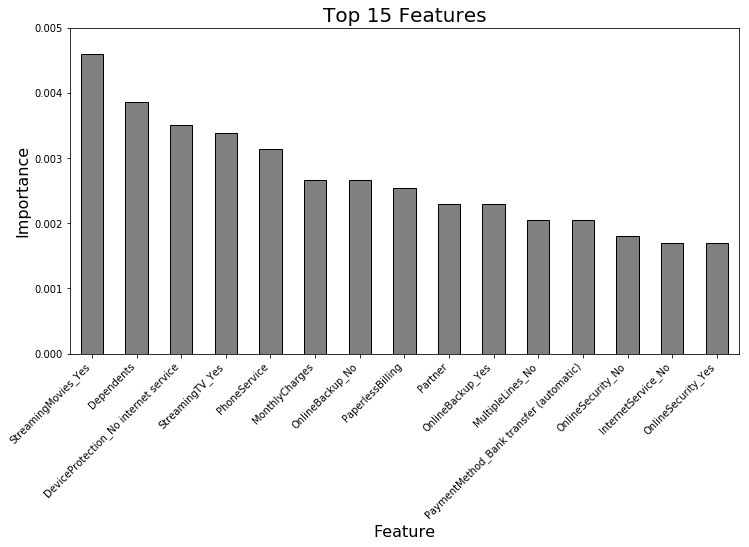

In [187]:
# plotting top 15 feature importances

feat_impt.head(15).plot(kind='bar', figsize=(12,6), color='gray', edgecolor='k', legend=None)
plt.title('Top 15 Features', fontsize=20)
plt.ylabel('Importance', fontsize=16)
plt.xlabel('Feature', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylim(0,0.005)

# Flagging customers at risk of churning

In [191]:
# Getting probabilities for positive class (churned)
proba_risk = grid_search_SVC_baseline.predict_proba(X_test)[:, 1]

In [218]:
# I consider a customer to be at high risk if probability of churned is greater than 70%.
at_risk = (np.where(proba_risk>0.70))

In [252]:
# Lets collect the index of subscribers at risk
risk_customer_index = []

for prob in at_risk:
    risk_individual = X_test.iloc[prob]
    risk_customer_index.append(risk_individual.index)

In [253]:
# Lets collect the subscriber id to specifically target them
risk_customer_ids = []

for idx in risk_customer_index:
    risk_customer = data_encoded.loc[idx]
    risk_customer_ids.append(risk_customer.customerID.values)

In [254]:
# List of subscriber ids from customers at risk of churning
np.set_printoptions(threshold=np.inf) # print all values without truncation
print('List of the Customer IDs from subscribers at high risk:')
print('\n', risk_customer_ids)

List of the Customer IDs from subscribers at high risk:

 [array(['0196-VULGZ', '1981-INRFU', '4770-UEZOX', '9540-JYROE',
       '6402-EJMWF', '0689-NKYLF', '2012-NWRPA', '9462-MJUAW',
       '4459-BBGHE', '2205-YMZZJ', '4059-IIEBK', '9208-OLGAQ',
       '0515-YPMCW', '9365-SRSZE', '8436-BJUMM', '9408-HRXRK',
       '3536-IQCTX', '7767-UXAGJ', '0701-RFGFI', '5168-MSWXT',
       '1197-BVMVG', '6365-MTGZX', '4547-KQRTM', '4815-GBTCD',
       '6243-OZGFH', '5380-AFSSK', '5281-BUZGT', '0196-JTUQI',
       '9728-FTTVZ', '2952-QAYZF', '5146-CBVOE', '0125-LZQXK',
       '8008-HAWED', '0524-IAVZO', '9191-MYQKX', '0576-WNXXC',
       '3787-TRIAL', '1941-HOSAM', '5057-LCOUI', '2761-XECQW',
       '6615-NGGZJ', '3757-NJYBX', '0812-WUPTB', '4441-NIHPT',
       '3721-CNEYS', '4548-SDBKE', '5759-RCVCB', '9529-OFXHY',
       '0504-HHAPI', '3640-PHQXK', '5233-GEEAX', '6022-UGGSO',
       '6496-JDSSB', '0682-USIXD', '9907-SWKKF', '9793-WECQC',
       '4587-VVTOX', '8059-UDZFY', '4115-NZRKS', '7284-BUYE